Here we will look at how the simulations project in typical IC / EC gate space

In [9]:
import matplotlib.pyplot as plt
import MDAnalysis as mda
import matplotlib as mpl
import numpy as np
from MDAnalysis.analysis import distances as d

import sys
sys.path.append('../') ## to get src lib
import src.analysis_functions as analysis_functions
import src.simulation_metadata as sims
from src.figure_parameters import figure_rc_params
import seaborn as sns


## Loading data

In [19]:
sim_list = [sims.PfHT_3361_crystal, sims.PfHT_3361_em,
            sims.PfHT_MMV12, sims.PfHT_MMV_crystal,
            sims.PfHT_apo]
color_l = [sim.color for sim in sim_list]


all_unis, all_lens = analysis_functions.load_unis(
    sim_list= sim_list
)

## can add 22 to resids here, so that we don't have to do counting!! Amazing
for sim in sim_list:
    for u_rep in all_unis[sim.name]:
        u_rep.add_TopologyAttr('resid', list(range(22, len(u_rep.residues)+22)))



## Functions

In [20]:
def get_gate_arr(
        sim: sims.SimulationMetadata,
        tm1_s: str='resid 44-49',
        tm7_s: str='resid 310-318',
        tm4_s: str='resid 145-153',
        tm10_s: str='resid 409-416',
        com: bool=True,
) -> np.array:
    ''' 
    calculate minimum distance between either all atoms in gate (com=False)
    or the min distance between centers of mass 
    return a np array with shape [n_replicas, 2, n_frames]
    where array[n,:,0] is ic gate and array[n,:,1] is ec gate    
    '''

    dists = np.zeros((sim.n_replicas,2000,2))
    dists[:] = np.nan

    for n,u_rep in enumerate(all_unis[sim.name]):
        tm1 = u_rep.select_atoms(tm1_s)
        tm7 = u_rep.select_atoms(tm7_s)
        tm4 = u_rep.select_atoms(tm4_s)
        tm10 = u_rep.select_atoms(tm10_s)

        for ts in u_rep.trajectory:
            if com:
                tm1_d = tm1.center_of_mass()
                tm7_d = tm7.center_of_mass()
                tm4_d = tm4.center_of_mass()
                tm10_d = tm10.center_of_mass()
            else:
                tm1_d = tm1.positions
                tm7_d = tm7.positions
                tm4_d = tm4.positions
                tm10_d = tm10.positions

            ec_gate = np.min(d.distance_array(tm1_d, tm7_d))
            ic_gate = np.min(d.distance_array(tm4_d, tm10_d))
            dists[n,ts.frame,0] = ic_gate
            dists[n,ts.frame,1] = ec_gate
    
    return dists



plotting functions

The `lighten_colors` function will help toggle the colors a bit. It works best between about 0.5 and 1.5. 1.5 will darken the colors but you need to apply absolute value to this output or it will be negative


In [43]:
def plot_ic_ec_time(
    fig: plt.Figure,
    ax: list[plt.Axes],
    data_ic_x: np.array,
    data_ic_y: np.array,
    data_ec_x: np.array,
    data_ec_y: np.array,
    label: str= '',
    color: str='black',
    ic_gate_minmax: tuple=(9,18),
    ec_gate_minmax: tuple=(7,16)
)-> (plt.Figure, plt.Axes):
    ''' 
    Makes 2 simple line plots stacked. Just plot one replica at a time
    Ax[0] is for the IC gate, ax[1] is for EC gate
    '''

    ax[0].plot(data_ic_x, data_ic_y, color=color, label=label)
    ax[0].set_xlim(0, data_ic_x[-1])
    ax[0].set_ylim(ic_gate_minmax)
    ax[0].set_ylabel('Intracellular gate (A)')

    ax[1].plot(data_ec_x, data_ec_y, color=color, label=label)
    ax[1].set_xlim(0, data_ec_x[-1])
    ax[1].set_ylabel('Extracellular gate (A)')
    ax[1].set_ylim(ec_gate_minmax)

    ax[1].set_xlabel('Time (ns)')

    plt.legend()
    return fig, ax


def plot_ic_ec_scatter(
    fig: plt.Figure,
    ax: list[plt.Axes],
    data_ic: np.array,
    data_ec: np.array,
    label: str= '',
    color: str='black',
    ic_gate_minmax: tuple=(9,18),
    ec_gate_minmax:tuple=(7,16),
    highlight_start: bool=True,
    kde: bool=True,
)-> (plt.Figure, plt.Axes):
    ''' 
    Makes 2 simple line plots stacked. Just plot one replica at a time
    Ax[0] is for the IC gate, ax[1] is for EC gate
    '''
    if highlight_start:
        ax.scatter(data_ic[0], data_ec[0], color=color, s=40, edgecolor='black',zorder=3,label=label)
        ax.scatter(np.mean(data_ic[-10:]), np.mean(data_ec[-10:]), color=color, s=50, edgecolor='grey',zorder=2)
    if not kde:
        ax.scatter(data_ic, data_ec, color=color)
    elif kde:
        sns.kdeplot(x=data_ic, y=data_ec, fill=True, color=color, alpha=0.5,thresh=0.01)
    ax.set_xlim(ic_gate_minmax)
    ax.set_ylim(ec_gate_minmax)
    ax.set_xlabel('Intracellular gate (A)')
    ax.set_ylabel('Extracellular gate (A)')

    plt.legend()
    return fig, ax



In [32]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

## actual code

If you want to plot different conditions together, you just have to change where you comment out the `fig, ax` and `plt.show()`

In [28]:
dist_dict = {}
for sim in sim_list:
    dist_dict[sim.name] = get_gate_arr(sim)

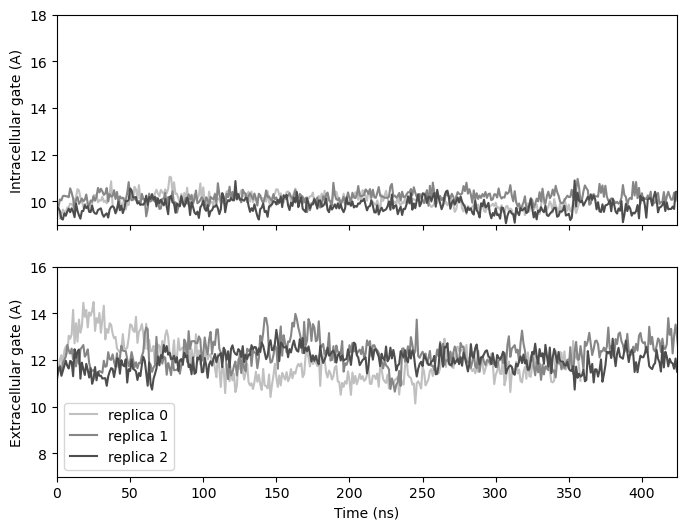

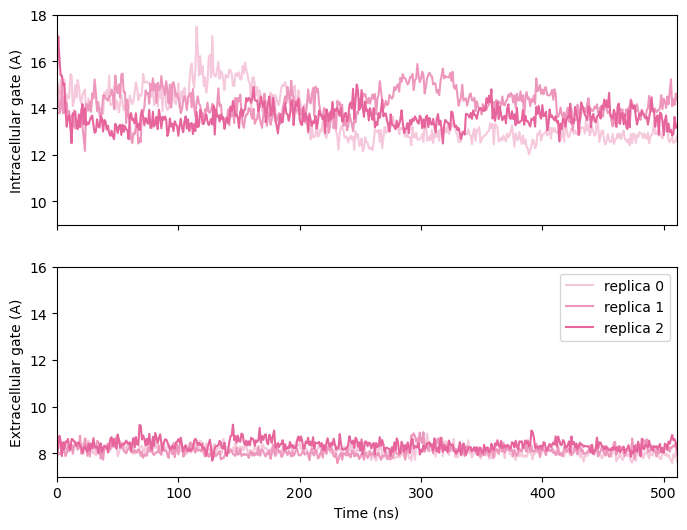

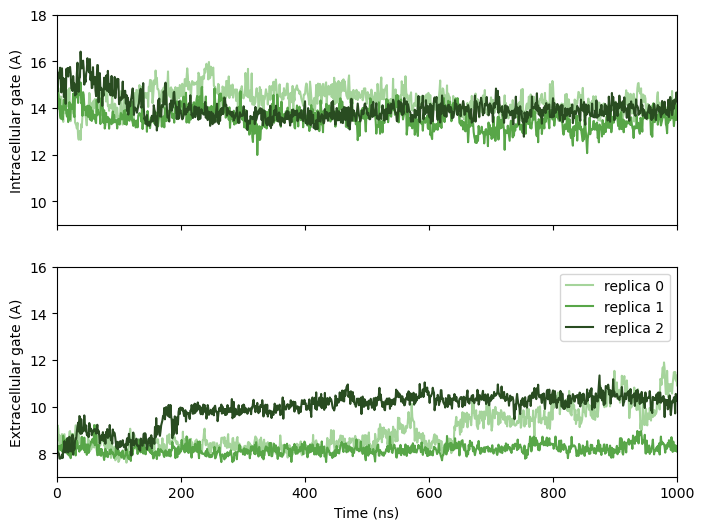

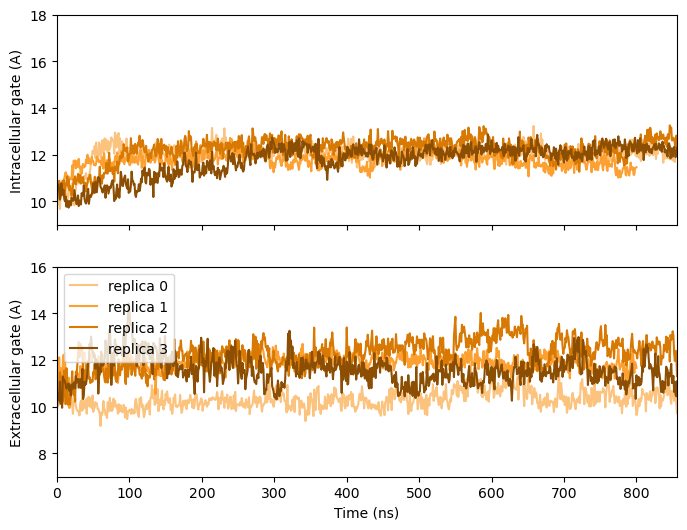

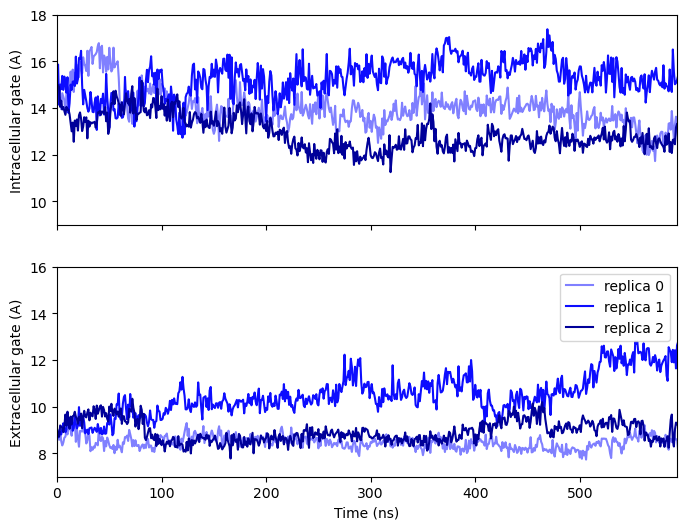

In [29]:
#fig,ax=plt.subplots(2,1,sharex=True,figsize=(8,6))
for sim in sim_list:
    fig,ax=plt.subplots(2,1,sharex=True,figsize=(8,6))
    colors = np.linspace(0.5,1.4,sim.n_replicas)

    for n,rep in enumerate(dist_dict[sim.name]):
        rep = rep[~np.isnan(rep).any(axis=1)] #drop nans, was around just for data storage ease

        plot_ic_ec_time(fig=fig,
                ax=ax,
                data_ic_x=np.arange(0, len(rep)),
                data_ic_y=rep[:,0],
                data_ec_x=np.arange(0, len(rep)),
                data_ec_y=rep[:,1],
                label=f'replica {n}',
                color=np.absolute(lighten_color(sim.color, colors[n]))
    )
    plt.show()
#plt.show()

##### I find it best to take the mean of the 3 replicas to show the gate distribution
You can do this easily by finding the mean across the 0th axis, and then remove any row left which has any nans

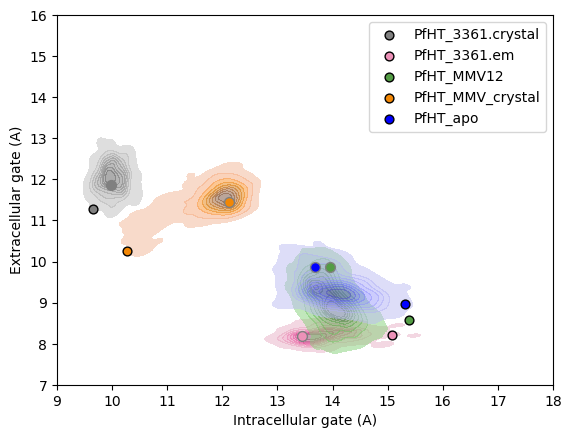

In [44]:
f,ax=plt.subplots(1,1)
for sim in sim_list:        
        mean_dist_dict = np.mean(dist_dict[sim.name],axis=0)
        mean_dist_dict = mean_dist_dict[~np.isnan(mean_dist_dict).any(axis=1)]

        plot_ic_ec_scatter(fig=fig,
                ax=ax,
                data_ic=mean_dist_dict[:,0],
                data_ec=mean_dist_dict[:,1],
                color=sim.color,
                label=sim.name
        )
plt.show()

In [41]:
mean_dist_dict[:,0]

array([15.32008194, 15.10292999, 14.5051885 , ...,         nan,
               nan,         nan])

<Axes: >

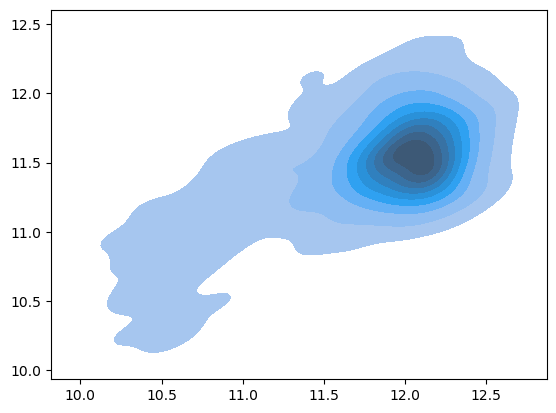

In [42]:
sns.kdeplot(x=mean_dist_dict[:,0], y=mean_dist_dict[:,1],fill=True,thresh=0.01)

Graveyard. Plotting mosiac looks cool but sort of a pain to wrangle this data for now

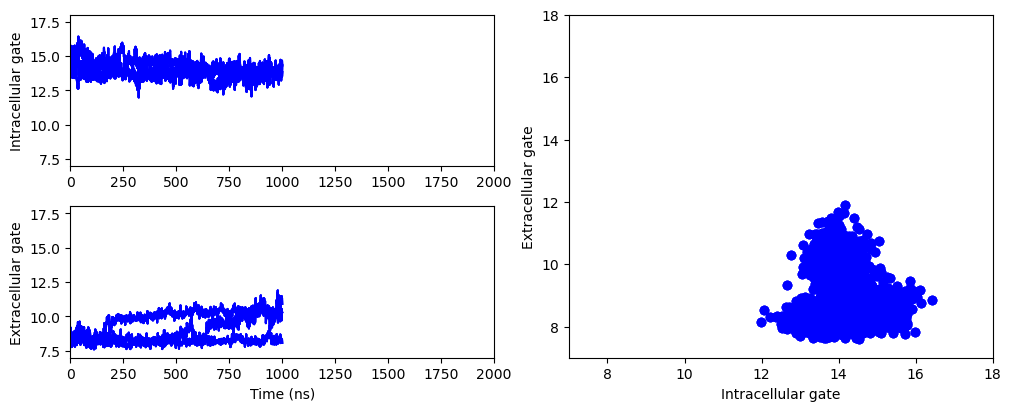

In [102]:
fig, axd = plt.subplot_mosaic("AC;BC", constrained_layout=True)


for rep in dists:

    plot_mosaic(fig,
                axd,
                data_A=rep[:,0], 
                data_B=rep[:,1], 
                data_C=rep, 
                color='blue')

In [54]:
def plot_mosaic(
            fig: plt.Figure,
            axd: plt.Axes,
            data_A: np.array, #ic gate
            data_B: np.array, #ec gate
            data_C: np.array, # np array with shape [2,n_frames]
            color: str,
            figsize: tuple=(10,4),
            gate_minmax: tuple=(7,18),
) -> (plt.Figure, plt.Axes):
    """ 
    Plots in a mosiac the ic gate, ec gate, and scatter of both
    Will return fig and axd dict so that you can tinker outside as need be
    """
    
    fig.set_size_inches(figsize)

    for rep in dists:
        axd['C'].scatter(data_C[:,0], data_C[:,1], color=color)
        axd['A'].plot(data_A, color=color)
        axd['B'].plot(data_B, color=color)

    axd['C'].set_xlabel("Intracellular gate")
    axd['C'].set_ylabel("Extracellular gate")
    axd['C'].set_ylim(gate_minmax)
    axd['C'].set_xlim(gate_minmax)
    
    axd['A'].set_ylabel('Intracellular gate')
    axd['A'].set_xlim(0,len(data_A))
    axd['A'].set_ylim(gate_minmax)

    axd['B'].set_ylabel('Extracellular gate')
    axd['B'].set_xlim(0,len(data_B))
    axd['B'].set_ylim(gate_minmax)
    axd['B'].set_xlabel('Time (ns)')
